In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import math
from sklearn.preprocessing import OneHotEncoder

### 데이터 분류 함수 정의

In [28]:
def split_dataset(dataset, test_ratio =0.3):
    test = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test],dataset[test]

In [40]:
#전처리
dataset = pd.read_csv("/Users/hongseunghyeog/Documents/penguins.csv")
#결측값 확인
dataset.isnull().sum()
#bill_length 결측값 처리
length_average = round(dataset['bill_length_mm'].mean(),1)
dataset['bill_length_mm']=dataset['bill_length_mm'].fillna(length_average)
#bill_depth 결측값 처리
depth_average = round(dataset['bill_depth_mm'].mean(),1)
dataset['bill_depth_mm']=dataset['bill_depth_mm'].fillna(depth_average)
#flipper_length 결측값 처리
flipper_average = round(dataset['flipper_length_mm'].mean(),0)
dataset['flipper_length_mm']=dataset['flipper_length_mm'].fillna(flipper_average)
#body_mass 결측값 처리
body_average = round(dataset['body_mass_g'].mean(),0)
dataset['body_mass_g']=dataset['body_mass_g'].fillna(body_average)
#sex 결측값 처리 => male의 비율이 조금 더 높기 때문에 male로 처리
rate = dataset['sex'].value_counts()
print(rate)
dataset['sex']=dataset['sex'].fillna('male')
dataset

sex
male      168
female    165
Name: count, dtype: int64


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,43.9,17.2,201.0,4202.0,male,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


학습 데이터, 테스트 데이터 분류

In [44]:
train_data,test_data = split_dataset(dataset)
print("{} examples in training, {} examples for testing.".format(len(train_data), len(test_data)))
label = 'species'
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label)
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=label)

250 examples in training, 94 examples for testing.


### 모델 생성 및 학습
모델 학습 진행

In [45]:
model_tree = tfdf.keras.RandomForestModel(verbose = 2)
model_tree.fit(train_dataset)

Use 8 thread(s) for training
Use /var/folders/ft/t6wj6swj4f5_ccmqyz7jgvph0000gn/T/tmpqzyuc93l as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'island': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'bill_length_mm': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'bill_depth_mm': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'flipper_length_mm': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'body_mass_g': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'sex': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'year': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>}
Label: Tensor("data_7:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'island': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>), 'bill_length_mm': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'bill_depth_mm

[INFO 24-03-28 15:14:07.3368 KST kernel.cc:771] Start Yggdrasil model training
[INFO 24-03-28 15:14:07.3383 KST kernel.cc:772] Collect training examples
[INFO 24-03-28 15:14:07.3383 KST kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-03-28 15:14:07.3391 KST kernel.cc:391] Number of batches: 1
[INFO 24-03-28 15:14:07.3391 KST kernel.cc:392] Number of examples: 250
[INFO 24-03-28 15:14:07.3394 KST kernel.cc:792] Training dataset:
Number of records: 250
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	1: "bill_depth_mm" NUMERICAL mean:17.2484 min:13.1 max:21.5 sd:2.0071

Model trained in 0:00:00.035814
Compiling model...
Model compiled.


### 모델 평가 진행

In [49]:
model_tree.compile(metrics=["accuracy"])
evaluation = model_tree.evaluate(test_dataset,return_dict=True)
print()
for name,result in evaluation.items():
    print(f"{name} : {result:.4f}")
model_tree.save("/Volumes/Code/Source/python/model")

1/1 [==============================] - 0s 101ms/step - loss: 0.0000e+00 - accuracy: 0.9787

loss : 0.0000
accuracy : 0.9787
INFO:tensorflow:Assets written to: /Volumes/Code/Source/python/model/assets


INFO:tensorflow:Assets written to: /Volumes/Code/Source/python/model/assets


model_plotter를 이용해서 모델을 시각화
결과는 Read.me에 게시

In [62]:
tree_idx = 0  # 시각화할 트리의 인덱스 (예: 첫 번째 트리)
tfdf.model_plotter.plot_model(model_tree, max_depth=3)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_341d91020be040de9128b1d2667acaf9"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

### 결과

In [68]:
# model_tree.summary()
model_tree.make_inspector().evaluation()

Evaluation(num_examples=250, accuracy=0.984, loss=0.07331667334027589, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

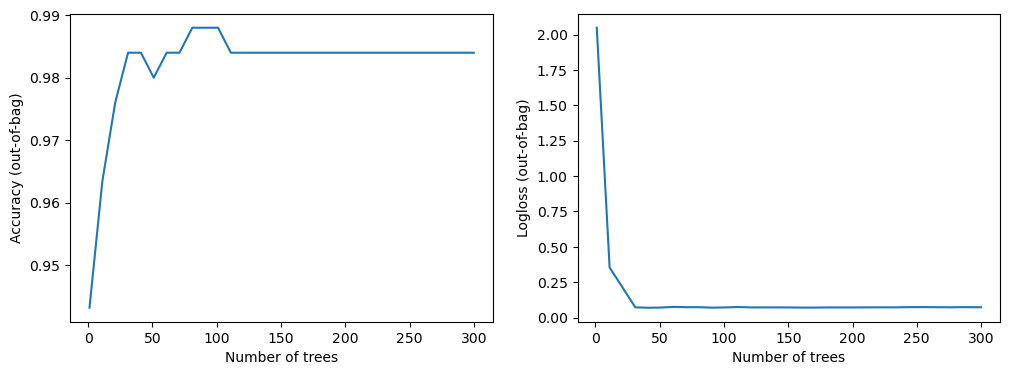

In [70]:
import matplotlib.pyplot as plt

logs = model_tree.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()